<a href="https://colab.research.google.com/github/sanaa-sys/Fraud-Detection/blob/main/Fraud_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,recall_score,precision_score, classification_report


In [ ]:
#Read Datasets
data_train = pd.read_csv("fraudTrain.csv")
data_test = pd.read_csv("fraudTest.csv")

In [ ]:
#Combine training and testing data for initial data analysis
data = pd.concat([data_train, data_test], axis=0)

In [ ]:
data.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [ ]:
data.drop(columns = [data.columns[0], data.columns[2], data.columns[6], data.columns[7], data.columns[9],  "trans_num"], inplace=True)


In [ ]:
#The data is highly imbalanced as number of fraud cases are way less than number of non-fraud cases
#which makes hard for traditional ML models to identify fraud cases accurately.
class_counts = data['is_fraud'].value_counts()
print("Class distribution:")
print(class_counts)

Class distribution:
is_fraud
0    1842743
1       9651
Name: count, dtype: int64


In [ ]:
# Separate features and target
features = data.drop('is_fraud', axis=1)
target= data['is_fraud']
features.dropna()
features

,trans_date_trans_time,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,job,dob,unix_time,merch_lat,merch_long
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,1325376018,36.011293,-82.048315
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1325376044,49.159047,-118.186462
2,2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,1325376051,43.150704,-112.154481
3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,1325376076,47.034331,-112.561071
4,2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,1325376186,38.674999,-78.632459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,2020-12-31 23:59:07,fraud_Reilly and Sons,health_fitness,43.77,M,Luray,MO,63453,40.4931,-91.8912,519,Town planner,1966-02-13,1388534347,39.946837,-91.333331
555715,2020-12-31 23:59:09,fraud_Hoppe-Parisian,kids_pets,111.84,M,Lake Jackson,TX,77566,29.0393,-95.4401,28739,Futures trader,1999-12-27,1388534349,29.661049,-96.186633
555716,2020-12-31 23:59:15,fraud_Rau-Robel,kids_pets,86.88,F,Burbank,WA,99323,46.1966,-118.9017,3684,Musician,1981-11-29,1388534355,46.658340,-119.715054
555717,2020-12-31 23:59:24,fraud_Breitenberg LLC,travel,7.99,M,Mesa,ID,83643,44.6255,-116.4493,129,Cartographer,1965-12-15,1388534364,44.470525,-117.080888


In [68]:
fraud_indexes = target[target['is_fraud'] == 1].index.tolist()
print("Indexes of fraud transactions:", fraud_indexes)

KeyError: 'is_fraud'

In [ ]:
#Feature Engineering

In [ ]:
#Calculate distance between merchant and customer
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    lat1_rad, lon1_rad = radians(lat1), radians(lon1)
    lat2_rad, lon2_rad = radians(lat2), radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [ ]:
features["distance"] = features.apply(lambda row: haversine_distance(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)

In [ ]:
features.drop(columns = ["lat", "long", "merch_lat", "merch_long"], inplace = True)


In [ ]:
features["dob"].dtype
features["dob"] = pd.to_datetime(data["dob"])


In [ ]:
# Define a function to calculate age
from datetime import datetime
def calculate_age(dob):
    today = datetime.today()
    age = today.year - dob.year
    if (today.month, today.day) < (dob.month, dob.day):
        age -= 1
    return age

In [ ]:
features['age'] = features['dob'].apply(calculate_age)
features.drop(columns = ["dob"], inplace = True)

In [ ]:
features.job.nunique()

497

In [ ]:
sector_bag = {
    "IT": ["engineer", "developer", "programmer", "software", "IT", "technician", "architect", "system", "network",
           "administrator", "data scientist", "cybersecurity", "web developer", "analyst", "database", "devops"],

    "Education": ["teacher", "professor", "educator", "trainer", "lecturer", "scientist", "Orthoptist", "tutor",
                  "principal", "instructor", "counselor", "academic", "researcher", "dean", "school", "headmaster"],

    "Healthcare": ["doctor", "nurse", "medical", "therapist", "pharmacist", "health", "surgeon", "dentist", "clinician",
                   "physician", "optometrist", "radiologist", "paramedic", "midwife", "veterinarian", "psychiatrist", "counselling"],

    "Finance": ["analyst", "accountant", "auditor", "banker", "financial", "investment", "controller", "broker",
                "consultant", "treasurer", "loan officer", "trader", "actuary", "economist", "portfolio", "credit"],

    "Marketing": ["manager", "executive", "specialist", "consultant", "advertising", "public relations", "strategist",
                  "director", "coordinator", "brand", "SEO", "content", "digital", "market research", "social media",
                  "copywriter"],

    "Manufacturing": ["operator", "mechanic", "assembler", "fabricator", "engineer", "technician", "welder",
                      "planner", "quality", "machinist", "production", "inspector", "supervisor", "foreman",
                      "toolmaker", "CNC"],

    "Retail": ["cashier", "salesperson", "store", "associate", "manager", "clerk", "shopkeeper", "merchandiser",
               "assistant", "retail", "customer service", "sales", "inventory", "buyer", "stocker", "checkout"],

      "Legal": ["lawyer", "attorney", "paralegal", "judge", "legal", "solicitor", "notary", "clerk", "litigator",
              "advocate", "barrister", "magistrate", "prosecutor", "defense", "compliance"],

    "Hospitality": ["chef", "waiter", "bartender", "host", "manager", "receptionist", "housekeeper", "concierge",
                    "caterer", "cook", "hotel", "tour guide", "event planner", "sous chef", "sommelier", "valet"],

    "Construction": ["builder", "carpenter", "electrician", "plumber", "architect", "project manager", "site manager",
                     "surveyor", "foreman", "bricklayer", "roofer", "civil engineer", "construction", "contractor",
                     "inspector", "draftsman"]
}

def assign_sector(x):
    for key in sector_bag:
        for role in sector_bag[key]:
            if x.find(role) != -1:
                return key
    return "Other"

In [ ]:
features["job_sector"] = features["job"].apply(assign_sector)
features.drop(columns = ["job", "city_pop", "zip", "city"], inplace = True)

In [ ]:
features.head(5)

,trans_date_trans_time,merchant,category,amt,gender,state,unix_time,distance,age,job_sector
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,NC,1325376018,78.597568,36,Healthcare
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,WA,1325376044,30.212176,46,Education
2,2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,220.11,M,ID,1325376051,108.206083,62,Other
3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,MT,1325376076,95.673231,57,Legal
4,2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,41.96,M,VA,1325376186,77.556744,38,Healthcare


In [ ]:
features["trans_date_trans_time"] = pd.to_datetime(features["trans_date_trans_time"])
features["is_weekend"] = features["trans_date_trans_time"].dt.day_name().apply(lambda x : int((x == "Friday") | (x == "Sunday") | (x == "saturday")))
def day_period(x):
    if x >=0 and x < 6: return "Night"
    elif x>= 6 and x <= 12: return "Morning"
    elif x> 12 and x <= 15: return "Afternoon"
    elif x> 15 and x <= 20: return "Evening"
    elif x> 20 and x <= 24: return "Night"


features["day_period"] = features["trans_date_trans_time"].dt.hour.apply(day_period)
features["trans_month"] = features["trans_date_trans_time"].dt.month_name()
features.drop(columns = ["trans_date_trans_time", "unix_time"], inplace = True)




In [ ]:
features["merchant"].nunique()

693

In [ ]:
# Step 1: Calculate fraud percentages for each merchant
merchant_groups = data.groupby('merchant')
fraud_percentage_dict = {}

for merchant, group in merchant_groups:
    total_trans = group.shape[0]
    total_fraud_trans = group[group["is_fraud"] == 1].shape[0]
    fraud_percentage_dict[merchant] = (total_fraud_trans / total_trans) * 100

# Step 2: Map the calculated percentages back to the DataFrame
features["fraud_merchant_pct"] = data["merchant"].map(fraud_percentage_dict)

In [ ]:
features.drop(columns = ["merchant"], inplace = True)
features

,category,amt,gender,state,distance,age,job_sector,is_weekend,day_period,trans_month,fraud_merchant_pct
0,misc_net,4.97,F,NC,78.597568,36,Healthcare,0,Night,January,1.357466
1,grocery_pos,107.23,F,WA,30.212176,46,Education,0,Night,January,0.992063
2,entertainment,220.11,M,ID,108.206083,62,Other,0,Night,January,0.189251
3,gas_transport,45.00,M,MT,95.673231,57,Legal,0,Night,January,0.241611
4,misc_pos,41.96,M,VA,77.556744,38,Healthcare,0,Night,January,0.305677
...,...,...,...,...,...,...,...,...,...,...,...
555714,health_fitness,43.77,M,MO,77.026148,58,Manufacturing,0,Night,December,0.246002
555715,kids_pets,111.84,M,TX,100.074420,24,Finance,0,Night,December,0.182482
555716,kids_pets,86.88,F,WA,80.759302,42,Other,0,Night,December,0.182260
555717,travel,7.99,M,ID,52.933240,58,Other,0,Night,December,0.261780


In [ ]:
#Model Training

In [ ]:
encoder=LabelEncoder()
features['category']=encoder.fit_transform(data['category'])
features['gender']=encoder.fit_transform(features['gender'])
features['state']=encoder.fit_transform(features['state'])
features['job_sector']=encoder.fit_transform(features['job_sector'])
features['day_period']=encoder.fit_transform(features['day_period'])
features['trans_month']=encoder.fit_transform(features['trans_month'])


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)
x_train

,category,amt,gender,state,distance,age,job_sector,is_weekend,day_period,trans_month,fraud_merchant_pct
1273644,4,166.80,1,33,118.568453,78,8,0,2,6,1.139839
601398,11,28.86,0,4,132.208394,53,8,0,1,11,0.988287
999645,2,37.93,0,44,31.778845,34,4,1,3,3,0.500263
1180310,9,18.70,1,15,133.995217,65,8,1,3,8,0.086319
213847,8,33.54,0,43,57.125396,53,3,0,3,11,1.271186
...,...,...,...,...,...,...,...,...,...,...,...
259178,9,2.33,0,6,113.247585,59,1,0,2,8,0.365579
117739,13,9.12,0,25,65.330250,37,8,0,1,1,0.166528
131932,6,118.27,0,32,35.642839,46,8,0,3,7,0.116788
671155,12,5.60,1,23,116.557377,82,8,1,2,10,0.684117


In [24]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
x_train_resampled

array([[-0.57037309,  0.60246272,  1.10100093, ...,  0.18988203,
         0.21417957,  1.24983817],
       [ 1.21910512, -0.256872  , -0.90826445, ..., -0.73648635,
         1.66662897,  0.94375783],
       [-1.08165258, -0.20036797, -0.90826445, ...,  1.1162504 ,
        -0.65729006, -0.04187526],
       ...,
       [ 1.47474486,  5.64047615,  1.10100093, ...,  1.1162504 ,
        -1.28043764,  0.55198929],
       [-0.57037309,  1.5381676 , -0.90826445, ...,  1.1162504 ,
        -0.11849933,  1.20582336],
       [ 1.21910512,  6.57839944, -0.90826445, ...,  1.1162504 ,
         1.4515195 ,  2.13232153]])

In [30]:
def evaluate_model(model, x_train, x_test, y_test, y_train):
  model.fit(x_train_resampled, y_train_resampled)
  y_pred = model.predict(x_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f"{model.__class__.__name__} Accuracy: {accuracy:.4f}")
  print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")
  print(".............")
  plt.figure(figsize=(10, 6))
  sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt = 'd')

XGBClassifier Accuracy: 0.9964

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368526
           1       0.61      0.89      0.72      1953

    accuracy                           1.00    370479
   macro avg       0.81      0.94      0.86    370479
weighted avg       1.00      1.00      1.00    370479

.............


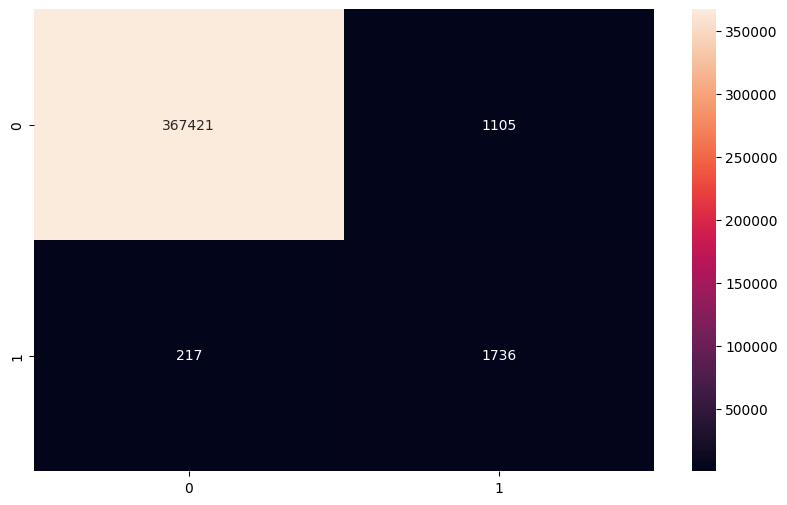

In [31]:
xgb_model = xgb.XGBClassifier(random_state=42)
evaluate_model(xgb_model, x_train_resampled, x_test, y_test, y_train_resampled)

In [ ]:
# You have:

# True Negative (TN): 367421 - Your model correctly predicted 367,421 instances as not fraud (negative class).
# False Positive (FP): 217 - Your model incorrectly predicted 217 instances as fraud when they were actually not fraud. This is also called a Type I error.
# False Negative (FN): 1105 - Your model incorrectly predicted 1105 instances as not fraud when they were actually fraud. This is also called a Type II error.
# True Positive (TP): 1736 - Your model correctly predicted 1736 instances as fraud (positive class).
# Interpretation:

# Overall, your model is doing a good job at identifying the negative class (non-fraudulent transactions) due to the high number of True Negatives.

# However, the model is missing a significant number of actual fraud cases (False Negatives). This could be a concern in fraud detection, as failing to identify fraudulent transactions can have serious consequences.

# The number of False Positives is relatively low, meaning the model isn't incorrectly flagging too many legitimate transactions as fraudulent.

# Metrics:

# You can use these values to calculate important performance metrics, such as:

# Accuracy: (TP + TN) / (TP + TN + FP + FN) - Overall correctness of the model.
# Precision: TP / (TP + FP) - How many of the predicted positive cases were actually positive.
# Recall (Sensitivity): TP / (TP + FN) - How many of the actual positive cases were correctly identified.
# F1-Score: 2 * (Precision * Recall) / (Precision + Recall) - A balanced measure of precision and recall.
# Focusing on Fraud Detection:

# Since correctly identifying fraud is crucial in your scenario, pay close attention to Recall and the F1-Score. These metrics highlight the model's ability to detect actual fraud cases. You might want to consider techniques to improve these if the current performance isn't satisfactory.



XGBClassifier Accuracy: 0.9493

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    368526
           1       0.09      0.98      0.17      1953

    accuracy                           0.95    370479
   macro avg       0.55      0.97      0.57    370479
weighted avg       1.00      0.95      0.97    370479

.............


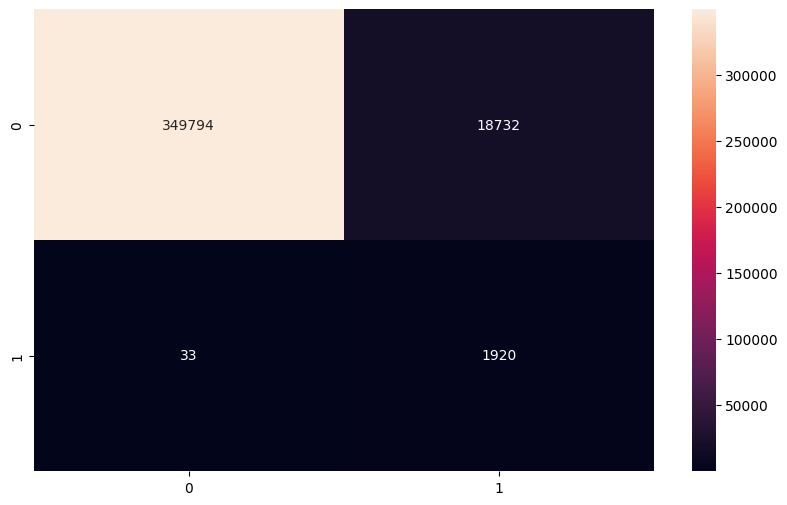

In [32]:
#Use hypertuning to increase recall
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight = scale_pos_weight, max_depth = 6, learning_rate = 0.1, n_estimators = 200, min_child_weight = 1, subsample = 0.8, colsample_bytree = 0.8)
evaluate_model(xgb_model, x_train_resampled, x_test, y_test, y_train_resampled)


In [34]:
# Get feature importances
importances = xgb_model.feature_importances_
feature_names = features.columns
# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
# Sort by importance
importance_df = importance_df.sort_values(by='importance', ascending=False)
importance_df

,feature,importance
1,amt,0.236006
8,day_period,0.221892
0,category,0.149745
10,fraud_merchant_pct,0.138207
9,trans_month,0.069670
2,gender,0.047530
5,age,0.047306
6,job_sector,0.031301
3,state,0.022838
4,distance,0.018940


In [59]:
from google.colab import userdata
import google.generativeai as genai

# Initialize Google Generative AI client
api_key = userdata.get('GEMINI_KEY')
genai.configure(api_key=api_key)
model = genai.GenerativeModel("gemini-1.5-pro")

In [60]:
def explain_prediction(features, prediction):
    feature_importance = xgb_model.feature_importances_
    top_features = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)[:5]

    prompt = f"""
    Explain the XGBoost model's fraud detection prediction based on the following information:

    Prediction: {"Fraud" if prediction == 1 else "Not Fraud"}
    Top 5 important features and their values:
    |feature |	importance
    |amt	   |   0.236006
    |day_period|	0.221892
    |category	 | 0.149745
    |fraud_merchant_pct	|  0.138207
    |trans_month	|  0.069670


    Provide a concise explanation of why the model made this prediction and how the top features contributed to it.
    """

    response = model.generate_content(prompt)
    return response.text


In [72]:
# Example usage
y_pred = xgb_model.predict(x_test)
#Change sample index
sample_index = 0
sample_features = x_test[sample_index]
sample_prediction = y_pred[sample_index]

explanation = explain_prediction(sample_features, sample_prediction)
print(f"\nSample prediction: {'Fraud' if sample_prediction == 1 else 'Not Fraud'}")
print("Explanation:")
print(explanation)


Sample prediction: Not Fraud
Explanation:
The XGBoost model predicted "Not Fraud" likely because the values for the top contributing features suggest a normal transaction.  While we don't have the *specific* values for each feature, we can infer their general impact:

* **`amt` (0.236):** The transaction amount was probably within a typical range.  Unusually high amounts are often associated with fraud.
* **`day_period` (0.222):** The time of day the transaction occurred was likely during normal business hours or a common spending period, rather than a red flag time like the middle of the night.
* **`category` (0.150):** The purchase category was likely a common one, not associated with higher fraud rates.
* **`fraud_merchant_pct` (0.138):**  Crucially, the percentage of fraudulent transactions historically linked to the merchant was likely low, significantly reducing the risk profile.
* **`trans_month` (0.070):**  The month of the transaction was likely not associated with increased 